In [1]:
import pandas as pd
import os
import numpy as np
import warnings
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.api import VAR
import polars as pl
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm, kurtosis, skew, mode
import seaborn as sns
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression

In [10]:
#-------------------------------------------------------#-------------------------------------------------------#
# The dataframe are created following the output of the LOBSTER data:
#     The variables for the message are (in order): Time: (expressed as second after 00:00); 
#                                   Event type: (1: submission of new l.o.: 2:Cancellation (partial del. of l.o.); 3:Deletion of l.o.; 4:Exec. of visible l.o.; 5: exec. of hidden l.o.; 6: cross trade; 7:trading halt indicator)
#                                   Order ID (0 for hidden order);
#                                   Size
#                                   Price: Dollar price times 10000. E.G. $91.14 -> 911400
#                                   Direction: -1 Sell, +1 Buy
#
#     VERY IMPORTANT: when event type = 7 it means the trades are halted, Price and Direction are setted to -1
#                     all the other to 0. When trading resume event type is 7 but PRICE = 1!!!!  
#-------------------------------------------------------#-------------------------------------------------------#

def dfmessage():
    warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

    data_cube_message = {}
    csv_directory_message = 'C:/Users/gabri/Desktop/Uni/Msc QF/2nd year/AlgoTrading/Paper/Data/Message' #Change with personal path, this must be a folder with inside only the "MESSAGE" files
    for file_name in os.listdir(csv_directory_message):
        if file_name.endswith('.csv'):  # Only process CSV files
            
            day_label = file_name[:16]
            
            file_path = os.path.join(csv_directory_message, file_name)
            df = pd.read_csv(file_path, header=None, skiprows=1)
            df = df.drop(df.columns[-1], axis=1)
            
            df.columns = ["Sec. After MidN", "Event Type", "Order ID", "Size", "Price", "Direction"]
            df["check"] = range(len(df))
            
            df["Direction"] = df["Direction"] * -1   #Convention of LOBSTER Dataset

            
            data_cube_message[day_label] = df
            print(f"**********Creating Dataframe for {day_label}**********", "\n")
    print("Dictionary for Trade Book created!!")
            
    return data_cube_message



dictmessage = dfmessage()


#-------------------------------------------------------#-------------------------------------------------------#
# The dataframe are created following the output of the LOBSTER data:
#     The variables for the order are (in order): Best Ask price
#                                                 Best Ask Size
#                                                 Best Bid Price
#                                                 Best Bid Size
#-------------------------------------------------------#-------------------------------------------------------#



def dforder():
    data_cube_orderbook = {}
    csv_directory_order = 'C:/Users/gabri/Desktop/Uni/Msc QF/2nd year/AlgoTrading/Paper/Data/OrderBook' #Change with personal path, this must be a folder with inside only the "ORDER" files

    for file_name in os.listdir(csv_directory_order):
        if file_name.endswith('.csv'):  
            
            day_label = file_name[:16]
            
            file_path = os.path.join(csv_directory_order, file_name)
            df = pd.read_csv(file_path, header=None, skiprows=1)
            
            df.columns = ["BestAsk Price", "BestAsk Size", "BestBid Price", "BestBid Size"]
            


          
            data_cube_orderbook[day_label] = df
            print(f"**********Creating Dataframe for {day_label}**********", "\n")
    print("Dictionary for LOB created!!")
    return data_cube_orderbook

dictorder = dforder()





**********Creating Dataframe for MSFT_2020-03-02_********** 

**********Creating Dataframe for MSFT_2020-03-03_********** 

**********Creating Dataframe for MSFT_2020-03-04_********** 

**********Creating Dataframe for MSFT_2020-03-05_********** 

**********Creating Dataframe for MSFT_2020-03-06_********** 

**********Creating Dataframe for MSFT_2020-03-09_********** 

**********Creating Dataframe for MSFT_2020-03-10_********** 

**********Creating Dataframe for MSFT_2020-03-11_********** 

**********Creating Dataframe for MSFT_2020-03-12_********** 

**********Creating Dataframe for MSFT_2020-03-13_********** 

**********Creating Dataframe for MSFT_2020-03-16_********** 

**********Creating Dataframe for MSFT_2020-03-17_********** 

**********Creating Dataframe for MSFT_2020-03-18_********** 

**********Creating Dataframe for MSFT_2020-03-19_********** 

**********Creating Dataframe for MSFT_2020-03-20_********** 

**********Creating Dataframe for MSFT_2020-03-23_********** 

********

In [28]:
#-------------------------------------------------------#-------------------------------------------------------#
#
#           The function dfjoiner(), joins the two dataframe (message, order), and only after it filters out all
#           the event we are not interested in, keepyng just event type (4,5) see above for reference. 
#
#
#-------------------------------------------------------#-------------------------------------------------------#




def dfjoiner():
    dictjoined = {}
    for i in dictmessage:
        res = pd.concat([dictmessage[i], dictorder[i]], axis=1)
        

  
        
        resf = res[res["Event Type"].isin([4, 5])]

        dictjoined[i] = resf
    return dictjoined

dictjoined = dfjoiner()


#-------------------------------------------------------#-------------------------------------------------------#
#
#           The function addvariables() adds the variables needed to do our analysis, look a the below markdown 
#           to see the computation
#
#
#-------------------------------------------------------#-------------------------------------------------------#

def addvariables():
    dictionary = {}
    for i in dictjoined:
        df = dictjoined[i]
        
        df["MidPrice"] = (df["BestAsk Price"] + df["BestBid Price"])/2
        df["MidPrice_t+1"] = df["MidPrice"].shift(-1)
        df["LN Return"] = np.log(df["MidPrice_t+1"]/df["MidPrice"])
        df["DepthImbalance"] = ((df["BestBid Size"] - df["BestAsk Size"]) / (df["BestBid Size"] + df["BestAsk Size"]))
        df = df[:-1]
        df["t"] = range(len(df))
        dictionary[i] = df
    return dictionary




We calculate $m_t$ as $\frac{(BestAsk Price)_t + (BestBidPrice)_t}{2}$, we then shift this time series one value up, and get on the same row $m_t$ and $m_{t+1}$, we find LN return: $ln(\frac{m_{t+1}}{m_t})$, finally we find the Depth Imbalance: $\frac{BestBid Size - BestAsk Size}{BestBid Size + BestAsk Size}$.

In [9]:
dbdata["MSFT_2020-03-02_"][-10:]

,Sec. After MidN,Event Type,Order ID,Size,Price,Direction,check,Signed Size,BestAsk Price,BestAsk Size,BestBid Price,BestBid Size,MidPrice,MidPrice_t+1,LN Return,DepthImbalance,t
1175536,57599.961129,5,0,900,1728300,-1,1175536,-900,1728500,21409,1728100,1400,1728300.0,1728300.0,0.000000,-0.877241,194188
1175537,57599.969503,5,0,100,1728300,-1,1175537,-100,1728500,21409,1728100,1400,1728300.0,1728300.0,0.000000,-0.877241,194189
1175538,57599.992278,5,0,146,1728300,-1,1175538,-146,1728500,21409,1728100,1400,1728300.0,1728300.0,0.000000,-0.877241,194190
1175539,57599.996801,5,0,100,1728300,-1,1175539,-100,1728500,21409,1728100,1400,1728300.0,1728250.0,-0.000029,-0.877241,194191
1175541,57599.999482,5,0,100,1728400,-1,1175541,-100,1728500,21409,1728000,9390,1728250.0,1728250.0,0.000000,-0.390240,194192
1175542,57599.999482,4,809841027,1195,1728500,1,1175542,1195,1728500,20214,1728000,9390,1728250.0,1728250.0,0.000000,-0.365626,194193
1175543,57599.999482,4,810693387,300,1728500,1,1175543,300,1728500,19914,1728000,9390,1728250.0,1728250.0,0.000000,-0.359132,194194
1175544,57599.999482,4,810693611,500,1728500,1,1175544,500,1728500,19414,1728000,9390,1728250.0,1728250.0,0.000000,-0.348007,194195
1175545,57599.999482,4,811006883,100,1728500,1,1175545,100,1728500,19314,1728000,9390,1728250.0,1728250.0,0.000000,-0.345736,194196
1175546,57599.999482,4,811044723,2300,1728500,1,1175546,2300,1728500,17014,1728000,9390,1728250.0,1728250.0,0.000000,-0.288744,194197


In [30]:
dictjoined["MSFT_2020-03-02_"]


,Sec. After MidN,Event Type,Order ID,Size,Price,Direction,check,BestAsk Price,BestAsk Size,BestBid Price,BestBid Size
0,34200.016237,5,0,15,1648300,-1,0,1649200,100,1648000,50
1,34200.018244,5,0,707,1649100,-1,1,1649200,100,1648000,50
2,34200.018343,5,0,100,1649100,-1,2,1649200,100,1648000,50
3,34200.018448,5,0,100,1649100,-1,3,1649200,100,1648000,50
4,34200.018466,5,0,77,1649100,-1,4,1649200,100,1648000,50
...,...,...,...,...,...,...,...,...,...,...,...
1175543,57599.999482,4,810693387,300,1728500,1,1175543,1728500,19914,1728000,9390
1175544,57599.999482,4,810693611,500,1728500,1,1175544,1728500,19414,1728000,9390
1175545,57599.999482,4,811006883,100,1728500,1,1175545,1728500,19314,1728000,9390
1175546,57599.999482,4,811044723,2300,1728500,1,1175546,1728500,17014,1728000,9390


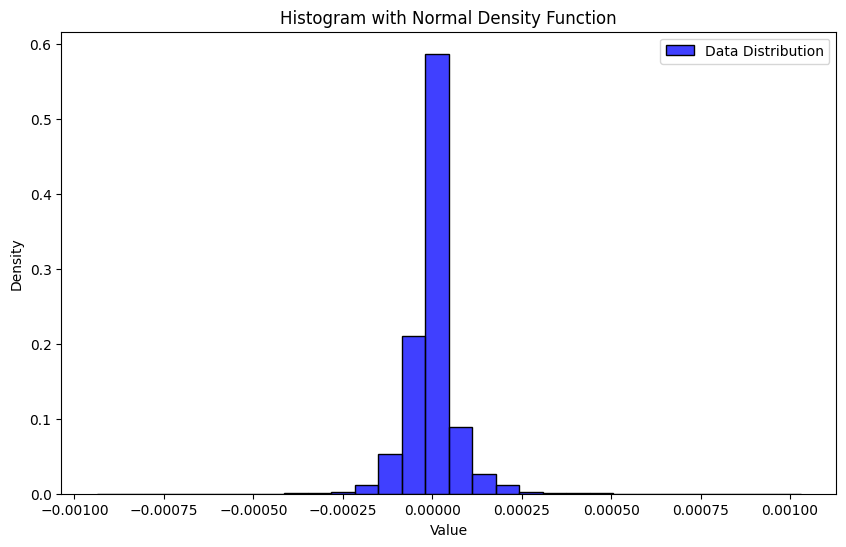

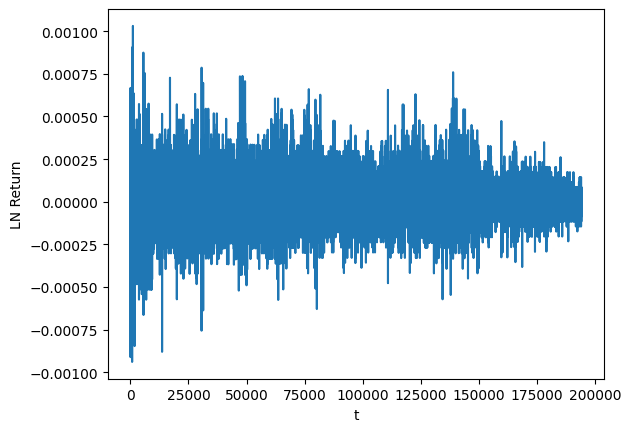

In [58]:
#-------------------------------------------------------#-------------------------------------------------------#
#
#           The function analyze_column() calculates some basic statistics of a variable inside a dataframe,
#           then plots the frequency distribution overlapping a Gaussian RV with mean = mean of the variable analyzed
#           and variance = variance of the variable analyzed.
#           It also plots the trend of the variable.
#-------------------------------------------------------#-------------------------------------------------------#

def analyze_column(a, var, scaling=1):
    data = a[var]*scaling

    i = a["t"]
    mean_val = np.mean(data)
    sd_val = np.std(data)
    mode_val = mode(data)
    median_val = np.median(data)
    kurtosis_val = kurtosis(data)
    skewness_val = skew(data)


    stats = {
        "mean": mean_val,
        "standard_deviation": sd_val,
        "mode": mode_val,
        "median": median_val,
        "kurtosis": kurtosis_val,
        "skewness": skewness_val,
    }

    
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=False, bins=30, color="blue", label="Data Distribution", stat="probability")    




    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title("Histogram with Normal Density Function")
    plt.legend()
    plt.show()


    sns.lineplot(a, x=i, y=data)

    

    return stats


statret = analyze_column(dbdata["MSFT_2020-03-02_"], "LN Return", 1)


In [13]:
n = dbdata["MSFT_2020-03-02_"]["LN Return"].value_counts(0)
print(n)

LN Return
 0.000000    89410
-0.000030       60
-0.000030       60
-0.000030       60
-0.000030       56
             ...  
 0.000269        1
-0.000244        1
-0.000210        1
-0.000120        1
-0.000087        1
Name: count, Length: 19530, dtype: int64


In [6]:
print(statret)

{'mean': 2.4296281602409284e-07, 'standard_deviation': 6.32917119321378e-05, 'mode': ModeResult(mode=0.0, count=89410), 'median': 0.0, 'kurtosis': 12.700167546253601, 'skewness': 0.534950136767634}


In [8]:
stats_df = pd.DataFrame(statret)

# Output the DataFrame as a LaTeX table
latex_table = stats_df.to_latex(index=False)
print(latex_table)

\begin{tabular}{rrrrrr}
\toprule
mean & standard_deviation & mode & median & kurtosis & skewness \\
\midrule
0.000000 & 0.000063 & 0.000000 & 0.000000 & 12.700168 & 0.534950 \\
0.000000 & 0.000063 & 89410.000000 & 0.000000 & 12.700168 & 0.534950 \\
\bottomrule
\end{tabular}



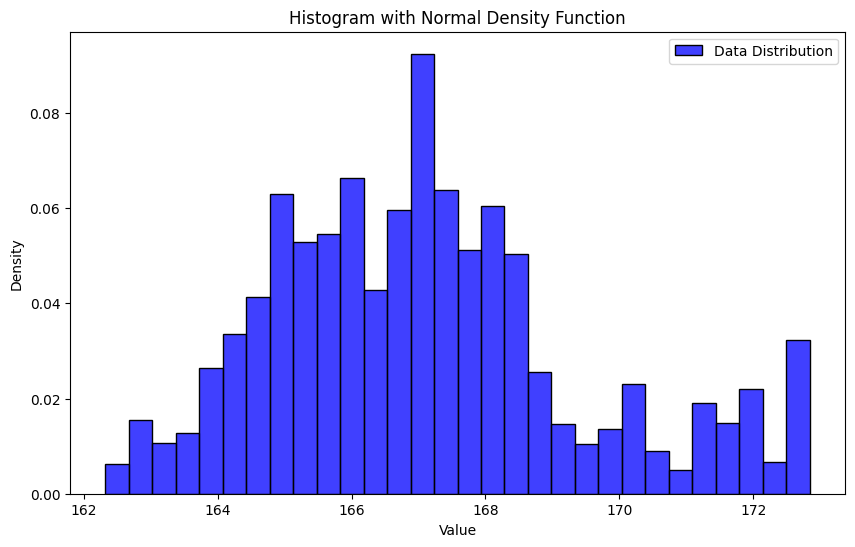

         mean  standard_deviation    mode  median  kurtosis  skewness
0  167.103073            2.334124  165.02  166.93 -0.018781  0.604481
1  167.103073            2.334124  711.00  166.93 -0.018781  0.604481
\begin{tabular}{rrrrrr}
\toprule
mean & standard_deviation & mode & median & kurtosis & skewness \\
\midrule
167.103073 & 2.334124 & 165.020000 & 166.930000 & -0.018781 & 0.604481 \\
167.103073 & 2.334124 & 711.000000 & 166.930000 & -0.018781 & 0.604481 \\
\bottomrule
\end{tabular}



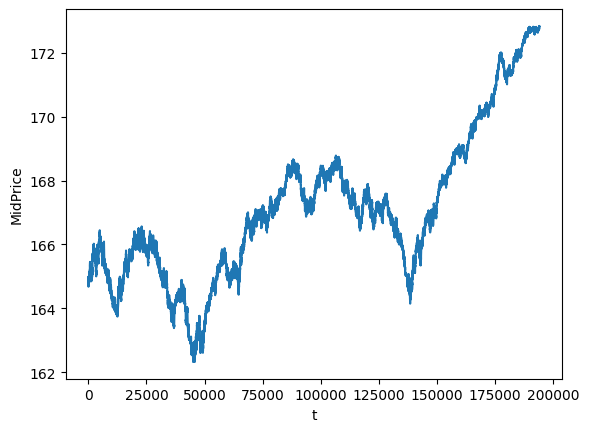

In [59]:
statprice = analyze_column(dbdata["MSFT_2020-03-02_"], "MidPrice", 1/10000)

stats_df_price = pd.DataFrame(statprice)
print(stats_df_price)

# Output the DataFrame as a LaTeX table
latex_table2 = stats_df_price.to_latex(index=False)
print(latex_table2)

In [21]:
#-------------------------------------------------------#-------------------------------------------------------#
#
#               The function adf() test with Augmented Dickey-Fuller, the stationarity of the desired time series
#               H0: presence of Unit Root vs H1: stationarity of time series
#
#
#-------------------------------------------------------#-------------------------------------------------------#
def adf(key, var):
    if key in dbdata:
        result = sm.tsa.adfuller(dbdata[key][var])

        print("\n")
        print("***********")
        print(f"Results for {key}, variable {var} are:")
        print("ADF Statistic:", result[0])
        print("p-value:", result[1])
        if result[1] < 0.05:
            print("We reject H0, the time series seems to be stationary")
        else:
            print("We fail to reject H0, the time series seems NOT stationary")

        print("Critical Values:")
        for crit_key, value in result[4].items():
            print(f"   {crit_key}: {value}")
        print("\n")
        print("***********")

adf("MSFT_2020-03-02_", "LN Return")



***********
Results for MSFT_2020-03-02_, variable LN Return are:
ADF Statistic: -90.73801024905958
p-value: 0.0
We reject H0, the time series seems to be stationary
Critical Values:
   1%: -3.4303836776246777
   5%: -2.861554885062037
   10%: -2.5667779227837952


***********


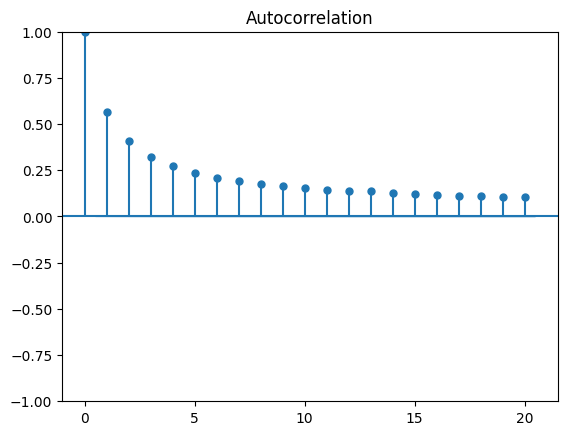

In [19]:
#-------------------------------------------------------#-------------------------------------------------------#
#
#       Here we plot the Auto correlation function for the variable "Direction"
#
#
#
#-------------------------------------------------------#-------------------------------------------------------#

sm.graphics.tsa.plot_acf(dbdata["MSFT_2020-03-02_"]["Direction"], lags=20)
plt.show()

In [9]:
acf_values = acf(dbdata["MSFT_2020-03-02_"]["Direction"], nlags=20, fft=False)

In [11]:
#-------------------------------------------------------#-------------------------------------------------------#
#
#       Looking at the shape of ACF we can assume the decaying is exponential, it is interesting to estimate the
#       decayng exponent. We estimate using a Linear Regression on the log/log trannsformation of the empirical
#       data. 
#
#-------------------------------------------------------#-------------------------------------------------------#
lags = np.arange(1, len(acf_values))  # Start from lag=1 to avoid ln(0)
acf_values_nonzero = acf_values[1:]   # Skip the first ACF value (lag=0)


ln_lags = np.log(lags)
ln_acf_values = np.log(acf_values_nonzero)


model = sm.OLS(ln_acf_values, ln_lags)
results = model.fit()


print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              1853.
Date:                Thu, 30 Jan 2025   Prob (F-statistic):                    2.10e-20
Time:                        12:55:27   Log-Likelihood:                          5.6034
No. Observations:                  20   AIC:                                     -9.207
Df Residuals:                      19   BIC:                                     -8.211
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#-------------------------------------------------------#-------------------------------------------------------#
#
#       Same as above but we add a constant to the regression. 
#
#-------------------------------------------------------#-------------------------------------------------------#

lags = np.arange(1, len(acf_values))  # Start from lag=1 to avoid ln(0)
acf_values_nonzero = acf_values[1:]   # Skip the first ACF value (lag=0)


ln_lags = np.log(lags)
ln_acf_values = np.log(acf_values_nonzero)
ln_lags_with_const = sm.add_constant(ln_lags)  #Adding a constant to the explanatory variable. 


model = sm.OLS(ln_acf_values, ln_lags_with_const)
results = model.fit()


print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           1.35e-26
Time:                        12:56:39   Log-Likelihood:                 51.341
No. Observations:                  20   AIC:                            -98.68
Df Residuals:                      18   BIC:                            -96.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5190      0.012    -41.550      0.0

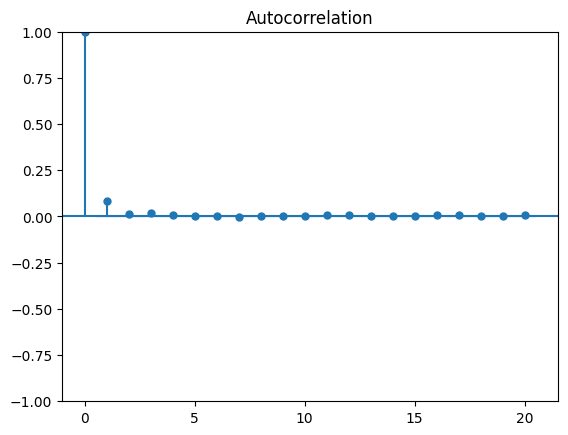

In [8]:
#-------------------------------------------------------#-------------------------------------------------------#
#
#       Same plot for LN Return, the acf dies very quickly as expected. 
#
#-------------------------------------------------------#-------------------------------------------------------#

sm.graphics.tsa.plot_acf(dbdata["MSFT_2020-03-02_"]["LN Return"], lags=20)
plt.show()

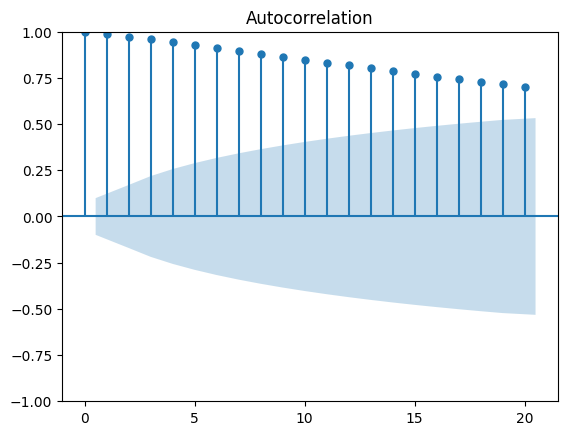

In [17]:
sm.graphics.tsa.plot_acf(dbdata["MSFT_2020-03-02_"]["MidPrice"][::500], lags=20)
plt.show()